In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Датасет Census  
https://archive.ics.uci.edu/ml/datasets/Census+Income  
Датасет был составлен Барри Беккером из базы данных о переписи населения 1994 года

Задачей классификации является предказать зарабатывает ли человек более 50000$ в год

In [2]:
url = "https://raw.githubusercontent.com/Pahandrovich/MachineLearningCourse/master/data/concatenated/adult_full.data"
data_raw = pd.read_csv(url,
                       names=['age','workclass','fnlwgt','education','education-num','marital-status',
                              'occupation','relationship','race','sex','capital-gain','capital-loss',
                              'hours-per-week','native-country','label'],
                       na_values=['?'],
                       sep=r'\s*,\s*',
                       engine='python')
data_raw.shape

(48842, 15)

In [3]:
data_raw.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**age**: возраст опрашиваемого  
**workclass**: Рабочий класс опрашиваемого (например госслужащий или частный предприниматель)  
**fnlwgt**: Сколько людей в оригинальной переписи было с такими параметрами (веса)  
**education**: образование  
**education-num**: образование в численном эквиваленте  
**marital-status**: Семейный статус  
**occupation**: род занятий (например вождение транспорта или военный)  
**relationship**: статус родства  
**race**: раса  
**sex**: пол  
**capital-gain**: прирост капитала.  
**capital-loss**: убыток капитала.  
**hours-per-week**: степень занятости в неделю (в часах)  
**native-country**: Страна проживания  

---  
Сделаем численное бинарное представление колонок *label* и *sex*, т.к. с  0 и 1 работать проще.  
Уберём из рассмотрения колонку *fnlwgt*, т.к. это количество подобных людей и к самому описанию человека не имеет отношения.  


In [4]:
data_raw['label'] = pd.factorize(data_raw['label'])[0]
data_raw['sex']   = pd.factorize(data_raw['sex'])  [0]
data_raw = data_raw.drop(['capital-loss'], axis=1)
data_raw = data_raw.drop(['capital-gain'], axis=1)
data_raw = data_raw.drop(['education'], axis=1)

In [5]:
data_raw['native-country'].value_counts()

United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

Видно, что подовляющее большинство людей проживает в **United-States**, поэтому заменим все остальные категориальные значения на **other**, в том числе и пустые значения.

In [6]:
data_raw.loc[data_raw["native-country"] != "United-States", "native-country"] = "Other"
data_raw.head(5)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,label
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,40,Other,0


Бинаризуем фичу **native-country** на 0 и 1

In [7]:
data_raw['native-country'] = pd.factorize(data_raw['native-country'])[0]

In [8]:
data_raw.head(5)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,label
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,0,40,0,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,0,13,0,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,0,40,0,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,40,0,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,40,1,0


# equivalents of binary feature
---
0 label ~ <= 50K  
1 label ~ >  50K  

---

0 sex ~ Male   
1 sex ~ Female 

---

0 native-country ~ United-States   
1 native-country ~ Other 

---

Выведем количество пустых значений и выкинем их, так как их не очень много

In [9]:
data_raw.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
hours-per-week       0
native-country       0
label                0
dtype: int64

In [10]:
data_raw = data_raw.dropna()
data_raw.isna().sum()

age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
hours-per-week    0
native-country    0
label             0
dtype: int64

In [11]:
data_raw['workclass'] = data_raw['workclass'].astype('category')
data_raw['marital-status'] = data_raw['marital-status'].astype('category')
data_raw['occupation'] = data_raw['occupation'].astype('category')
data_raw['relationship'] = data_raw['relationship'].astype('category')
data_raw['race'] = data_raw['race'].astype('category')
data_raw['native-country'] = data_raw['native-country'].astype('category')

Text(0, 0.5, 'education-num')

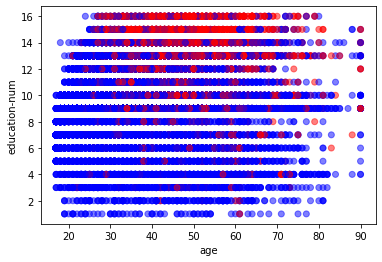

In [12]:
plt.scatter(data_raw['age'], data_raw['education-num'], color = np.array(('b', 'r'))[data_raw['label']], alpha = 0.5)
plt.xlabel('age')
plt.ylabel('education-num')

Из диаграммы видно, что более образованные люди чаще получают более 50K. Также видно, что очень молодые (примерно до 26 лет) зарабатывают менее 50к

C:\Users\Pavel\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


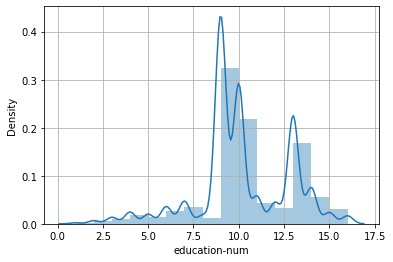

In [13]:
sns.distplot(data_raw['education-num'], bins=15)
plt.grid()

C:\Users\Pavel\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


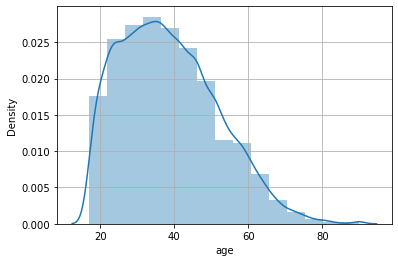

In [14]:
sns.distplot(data_raw['age'], bins=15)
plt.grid()

Большинство имеет среднее образование и выше,  а также видно, что в выборке в основном данные о людях до 60 лет

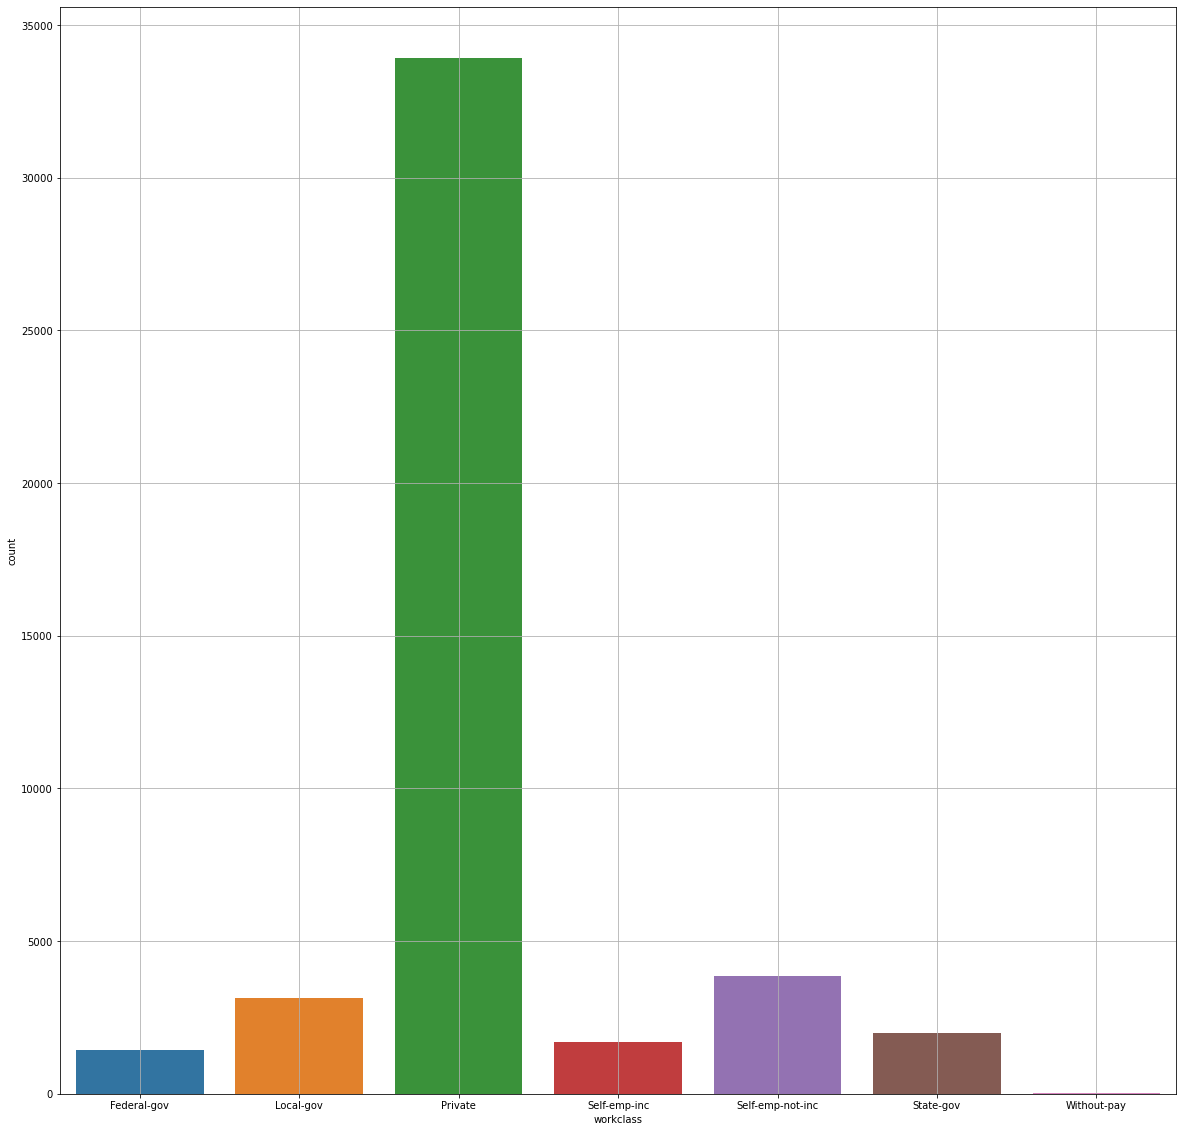

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
sns.countplot(ax=ax, x="workclass", data=data_raw)
plt.grid()

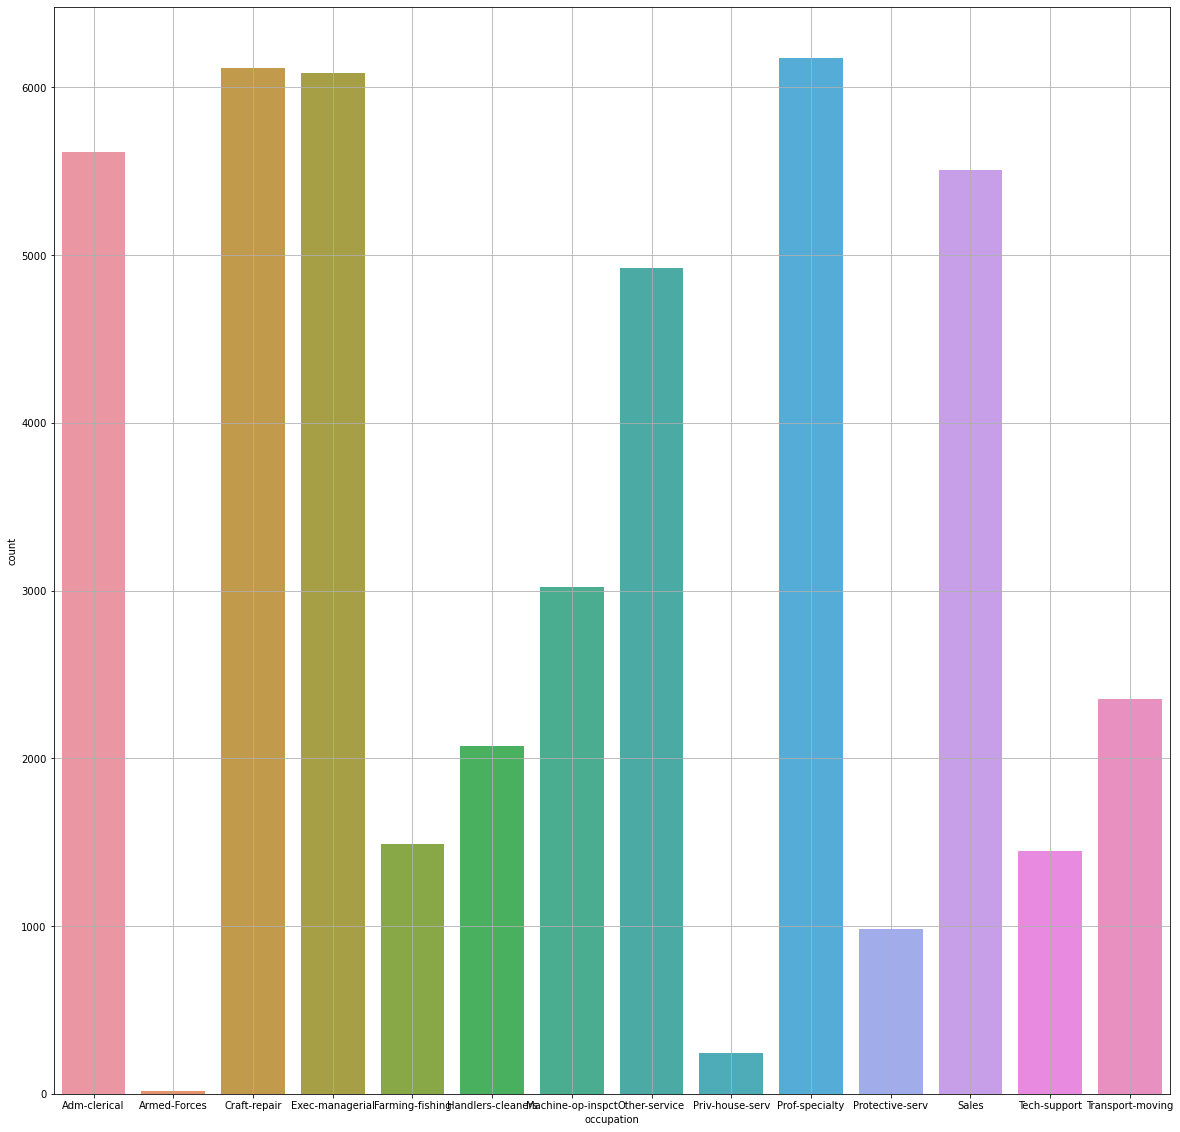

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
sns.countplot(ax=ax, x="occupation", data=data_raw)
plt.grid()

Дропнем строки, с маленьким количеством конкретных категориальных значений, конкретно это **'Without-pay'** для *workclass*;  
**'Armed-Forces'** и **'Priv-house-serv'** для *occupation*; Также уберём из выборки пожилых людей старше _84_ лет

In [17]:
print(data_raw.shape)
rows_to_drop = data_raw[
    (data_raw['age'] >= 86) |
    (data_raw['workclass'] == 'Without-pay') | (data_raw['occupation'] == 'Priv-house-serv') | 
    (data_raw['occupation'] == 'Armed-Forces')].index
data = data_raw.drop(rows_to_drop)
print(data.shape)

(46033, 12)
(45699, 12)


Избавимся от категориальных признаков с помощью **LabelEncoder**, когда каждому категориальному значению ставится в соответствие числовое

In [18]:
from sklearn.preprocessing import LabelEncoder

# workclass
le_workclass = LabelEncoder()
le_workclass.fit(data['workclass'])
data['workclass'] = le_workclass.transform(data['workclass'])
# marital-status
le_marital_status = LabelEncoder()
le_marital_status.fit(data['marital-status'])
data['marital-status'] = le_marital_status.transform(data['marital-status'])
# occupation
le_occupation = LabelEncoder()
le_occupation.fit(data['occupation'])
data['occupation'] = le_occupation.transform(data['occupation'])
# relationship
le_relationship = LabelEncoder()
le_relationship.fit(data['relationship'])
data['relationship'] = le_relationship.transform(data['relationship'])
# race
le_race = LabelEncoder()
le_race.fit(data['race'])
data['race'] = le_race.transform(data['race'])

In [19]:
data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,label
0,39,5,77516,13,4,0,1,4,0,40,0,0
1,50,4,83311,13,2,2,0,4,0,13,0,0
2,38,2,215646,9,0,4,1,4,0,40,0,0
3,53,2,234721,7,2,4,0,2,0,40,0,0
4,28,2,338409,13,2,7,5,2,1,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,2,245211,13,4,7,3,4,0,40,0,0
48837,39,2,215419,13,0,7,1,4,1,36,0,0
48839,38,2,374983,13,2,7,0,4,0,50,0,0
48840,44,2,83891,13,0,0,3,1,0,40,0,0


In [20]:
#sns.pairplot(data.drop(["native-country", "sex"], axis=1), hue='label', diag_kind='hist')
#plt.legend()

<AxesSubplot:>

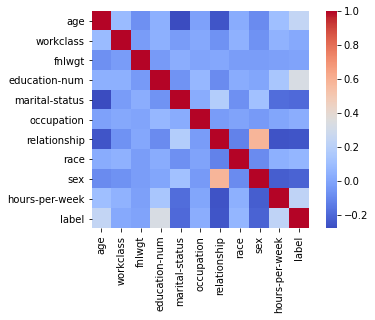

In [21]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')

Из матрицы корреляции видно, что _label_ лучше всего коррелирует с образованием и возрастом

In [22]:
data_with_samples = data
dataset = data_with_samples.drop(['fnlwgt'], axis=1)
X = dataset.drop(['label'], axis=1)
y = dataset['label']

In [23]:
print(X.shape)
print(y.shape)

(45699, 10)
(45699,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### KNeighborsClassifier

Лучшая точность на тестовой выборке: 0.8052516411378556
При k = : 6


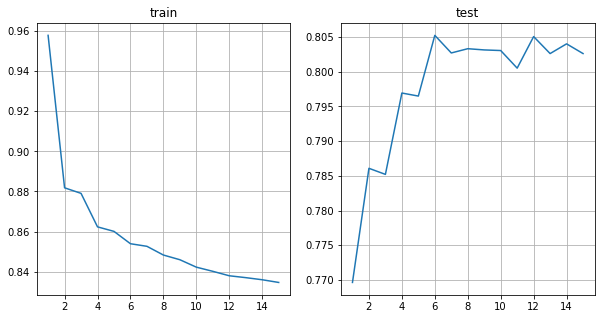

In [25]:
min_k = 1
max_k = 15
scores_train = []
scores_test = []
for k in range(min_k,max_k + 1):
    knc = KNeighborsClassifier(n_neighbors = k)
    knc.fit(X_train, y_train)
    scores_train.append(knc.score(X_train,y_train))
    scores_test.append(knc.score(X_test,y_test))

#plt.plot(range(min_k,max_k + 1),scores_train)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))

print(f"Лучшая точность на тестовой выборке: {max(scores_test)}")
print(f"При k = : {scores_test.index(max(scores_test)) + min_k}")

ax[0].set_title("train")
ax[0].plot(range(min_k,max_k + 1),scores_train)
ax[1].set_title("test")
ax[1].plot(range(min_k,max_k + 1),scores_test)
ax[0].grid(True)
ax[1].grid(True)
plt.show()

алгоритм достиг неплохой точности на тестовой выборке в 80.3% при К=10

### RandomForestClassifier

In [26]:
rfc = RandomForestClassifier(
                 n_estimators=100,
                 criterion="gini",
                 max_depth=4,
                 min_samples_split=2,
                 min_samples_leaf=5,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=42,
                 verbose=0,
                 warm_start=False,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None)
rfc.fit(X_train,y_train)
print(f"train score = {rfc.score(X_train,y_train)}")
print(f"test  score = {rfc.score(X_test,y_test)}")

train score = 0.8157203711268016
test  score = 0.8137417943107221


алгоритм достиг неплохой точности на тестовой выборке в 81.3%

Применим этот же алгоритм с весами, которые были в исходном датасете

In [27]:
X_sample = data_with_samples.drop(['label'], axis=1)
y_sample = data_with_samples['label']
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample,
                                                                y_sample, test_size = 0.25, random_state = 42)

samples_train = X_train_sample["fnlwgt"]
X_train_no_sample = X_train_sample.drop(['fnlwgt'], axis=1)

samples_test = X_test_sample["fnlwgt"]
X_test_no_sample = X_test_sample.drop(['fnlwgt'], axis=1)

In [28]:
rfc = RandomForestClassifier(
                 n_estimators=100,
                 criterion="gini",
                 max_depth=4,
                 min_samples_split=2,
                 min_samples_leaf=5,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=42,
                 verbose=0,
                 warm_start=False,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None)
rfc.fit(X_train_no_sample, y_train_sample, samples_train)
print(f"train score = {rfc.score(X_train_no_sample, y_train_sample, samples_train)}")
print(f"test  score = {rfc.score(X_test_no_sample, y_test_sample, samples_test)}")

train score = 0.8190753056877819
test  score = 0.813792772565969


Видно, что точность подросла, но не сильно

### LogisticRegression
Применим Логистическую регрессию при варьировании параметра регуляризации

Лучшая точность на тестовой выборке: 0.7986870897155361
При c = : 0.5


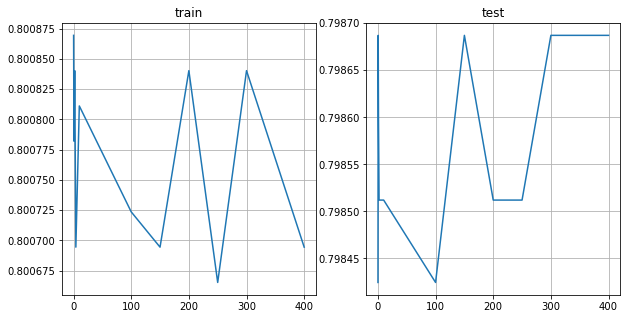

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

scores_train = []
scores_test = []
max_score = 0
max_score_c = 0

CC = [0.1, 0.5, 1.0, 2.0, 4.0, 10.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0]

for c in CC:
    log_reg = LogisticRegression(C = c, max_iter = 400, random_state = 42)
    log_reg.fit(X_train, y_train)
    scores_train.append(log_reg.score(X_train,y_train))
    test_score = log_reg.score(X_test,y_test)
    scores_test.append(test_score)
    if max_score < test_score: max_score = test_score ; max_score_c = c


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))

print(f"Лучшая точность на тестовой выборке: {max_score}")
print(f"При c = : {max_score_c}")

ax[0].set_title("train")
ax[0].plot(CC,scores_train)
ax[1].set_title("test")
ax[1].plot(CC,scores_test)
ax[0].grid(True)
ax[1].grid(True)
plt.show()

Видно, что c помощью регуляризации удалось достичь хороших результатов, но ошибка на тестовой выборке всё равно больше чем в модели RandomForest

### SVM
Применим SVM с радиальным ядром

In [30]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train,y_train)
print(f"train score = {svm.score(X_train,y_train)}")
print(f"test  score = {svm.score(X_test,y_test)}")

train score = 0.8025908852191165
test  score = 0.8026258205689278


SVM не даёт выигрыша по точности по сравнению с RF

# Вторая часть

Применим PCA и LDA.transform для понижения размерности

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

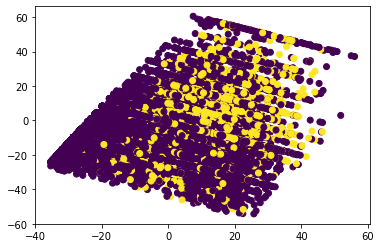

In [32]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca2 = pca.transform(X)

fig, ax = plt.subplots()

ax.scatter(X_pca2[:,0], X_pca2[:,1],
           c = y.values)
plt.show()

Применение LDA позволяет сократить размерность максимум до min(nClasses-1, nFeatures), в нашем случае это 1-мерное пространство

In [33]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X, y)
X_lda = lda.transform(X)
X_lda

array([[0.62670204],
       [0.8535398 ],
       [0.25837432],
       ...,
       [1.45157647],
       [1.08250133],
       [1.46011981]])

нарисуем это на прямой

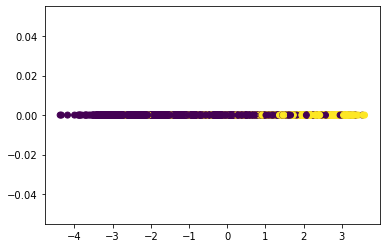

In [34]:
fig, ax = plt.subplots()

ax.scatter(X_lda[:,0], [0]*len(X_lda),
           c = y.values)
plt.show()

Видно, что много экземпляров первого и второго класса пересекаются, однако чётко видно, что в одной части больше элементов одного класса, а в другой части другого класса  
Тоже самое можно сказать про PCA с 2 компонентами


Применим еще один метод понижения размерности TSNE, который чаще всего используют для визуализации многомерных данных. Он позволяет сократить размерность ниже 4

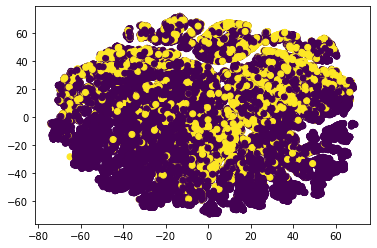

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots()

ax.scatter(X_tsne[:,0], X_tsne[:,1],
           c = y.values)
plt.show()

Применим для различного количества компонент алгоритм случайного леса, так как на оригинальных данных он показал наилучший результат

n components: 2
	train score = 0.7526696621345627
	test  score = 0.7513347921225383
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 3
	train score = 0.7589718153702515
	test  score = 0.758074398249453
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 4
	train score = 0.7970181478671879
	test  score = 0.7873960612691466
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 5
	train score = 0.8053626655774057
	test  score = 0.7993873085339168
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 6
	train score = 0.810993756200035
	test  score = 0.8047264770240701
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 7
	train score = 0.807375853416584
	test  score = 0.799562363238512
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 8
	train score = 0.8086304487366517
	test  score = 0.8028884026258206
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n components: 9
	train score = 0.8153702515025967
	test  sc

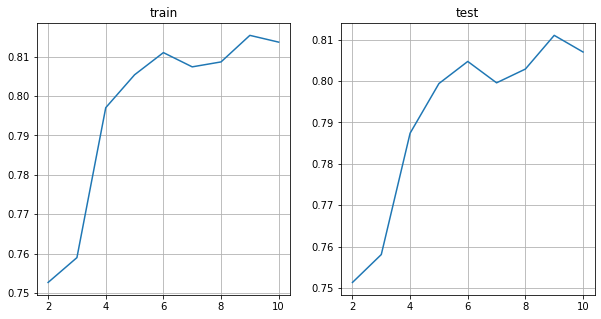

In [36]:
min_n = 2
max_n = 10
scores_train = []
scores_test = []
max_score = 0
max_score_n = 0
for n in range(min_n,max_n + 1):
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.25, random_state = 42)
    rfc = RandomForestClassifier(
                     n_estimators=100,
                     criterion="gini",
                     max_depth=4,
                     min_samples_split=2,
                     min_samples_leaf=5,
                     min_weight_fraction_leaf=0.,
                     max_features="auto",
                     max_leaf_nodes=None,
                     min_impurity_decrease=0.,
                     min_impurity_split=None,
                     bootstrap=True,
                     oob_score=False,
                     n_jobs=None,
                     random_state=42,
                     verbose=0,
                     warm_start=False,
                     class_weight=None,
                     ccp_alpha=0.0,
                     max_samples=None)
    rfc.fit(X_train,y_train)
    test_score = rfc.score(X_test,y_test)
    train_score = rfc.score(X_train,y_train)
    print(f"n components: {n}")
    print(f"\ttrain score = {train_score}")
    print(f"\ttest  score = {test_score}")
    print("~"*50)
    scores_train.append(train_score)
    scores_test.append(test_score)
    
    
    if max_score < test_score: max_score = test_score ; max_score_n = n

print(f"Лучшая точность на тестовой выборке: {max_score}")
print(f"При n components = : {max_score_n}")
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))
ax[0].set_title("train")
ax[0].plot(range(min_n,max_n + 1),scores_train)
ax[1].set_title("test")
ax[1].plot(range(min_n,max_n + 1),scores_test)
ax[0].grid(True)
ax[1].grid(True)
plt.show()

Результат на тестовой и трейновой выборках не сильно отличается. Наилучшее количество компонент - 10.  
  
В итоге видно, что ошибка возрастает с увеличением числа компонент, однако  начиная с 7 компонент точность прибавляется по малу. Поэтому можно сделать вывод, что 4 признака не сильно влияют на результат. Также видно, что PCA не позволяет повысить точность, но уменьшение размерности до 2 или 3 помогает понять некоторые особенности данных.

### Применим для на датасета алгоритмы кластеризации
#### KMeans

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

kmeans_random_init6 = KMeans(n_clusters=2, random_state=6).fit(X)
print(f"точность при одной инизиализации: {accuracy_score(y, kmeans_random_init6.labels_)}")
kmeans_random_init3 = KMeans(n_clusters=2, random_state=4).fit(X)
print(f"точность при другой инизиализации: {accuracy_score(y, kmeans_random_init3.labels_)}")

точность при одной инизиализации: 0.6339307205846955
точность при другой инизиализации: 0.3665288080701985


Видно, что точность с разной начальной инициализацией кластеров сильно отличается  
Применим KMeans для размерности 2 после PCA

точность для размерности 2: 0.6334930742467012


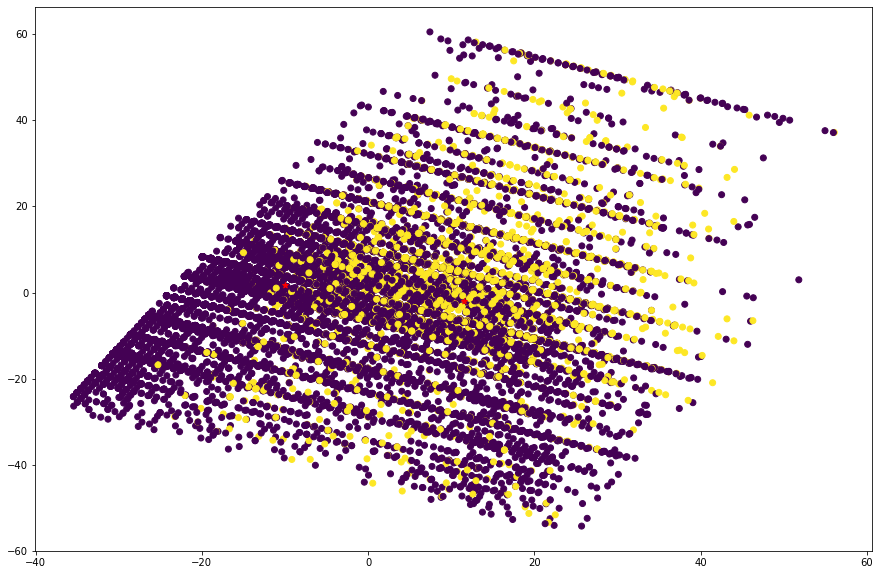

In [38]:
kmeans_pca2 = KMeans(n_clusters=2, random_state=6).fit(X_pca2)
print(f"точность для размерности 2: {accuracy_score(y, kmeans_pca2.labels_)}")
centers = kmeans_pca2.cluster_centers_
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(X_pca2[:,0], X_pca2[:,1],
           c = y.values)
ax.scatter(centers[:,0], centers[:,1], marker="*",
           c = "red")

plt.show()

Видно, что один кластер находится левее, другой правее, что соотносится с цветами классов

#### DBSCAN

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=1500).fit(X)
np.unique(dbscan.labels_)

array([-1,  0], dtype=int64)

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

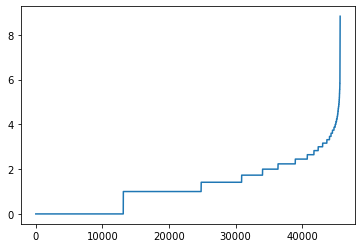

In [40]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1500)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

точность DBSCAN для размерности 2: 0.5581084925271887


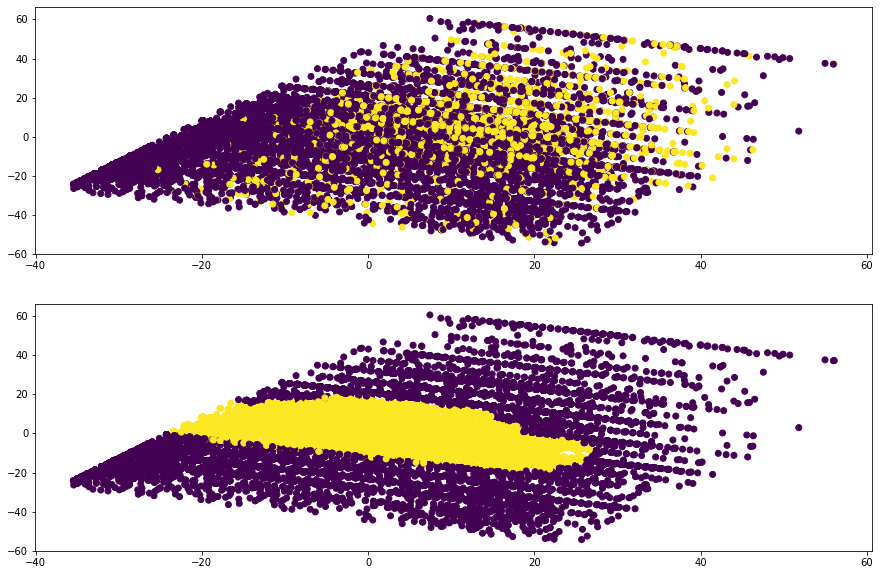

In [41]:
dbscan2 = DBSCAN(eps=5, min_samples=1500).fit(X_pca2)
print(f"точность DBSCAN для размерности 2: {accuracy_score(y, dbscan2.labels_)}")
fig, ax = plt.subplots(nrows = 2,figsize=(15,10))

ax[0].scatter(X_pca2[:,0], X_pca2[:,1],
           c = y.values)
ax[1].scatter(X_pca2[:,0], X_pca2[:,1],
           c = dbscan2.labels_)

plt.show()

На двумерных данных видно, что DBSCAN плохо справляется с этой задачей, так как все данные расположены достаточно плотно друг к другу и нет четко выраженных кластеров